# Summary

## Problem
    Can verbal deception be predicted with machine learning?

## Approach
### 2 datasets for machine learning
    The standard in natural language processing is to normalize text, i.e., distill content in statements by
    removing frequent words (i.e., stopwords), punctuation, etc.
    But, given the statistics from the data analysis revealed that the frequency of stopwords, punctuation, etc.
    varied with statistical difference in lies versus truth, 
    I hypothesize that normalization may lower the ability for machine learning algorithms to predict deception.
    To test this hypothesis, I will compare a lightly normalized permutation of the raw statements to a 
    fully normalized permutation.
#### Dataset 1 - Lightly normalized statements
    Statement words were converted to lowercase, and the following were removed: 
    whitespaces, html tags, accented characters, and extra new lines
#### Dataset 2 - Fully normalized statements
    "Lightly normalized statements" were lemmatized and additionally had the following removed: 
    punctuation, stopwords, non-alphabetic characters
## Results
### Datasets
    In most cases, lightly normalized statements were better able to predict the test data
### BoW VS n-GRAM = 1-2 VS n-GRAM = 1-3 vs Tfidf
    n-grams of size 1-2 or 1-3 outperformed other models equally well
### Multinomial Naive Bayes (mnb) VS Logistic Regression (lgr) VS Random Forests
    Multinomial Naive Bayes and Logistic Regression outperformed random forests; MNB and LR did equally well
    Optimizing for accuracy delivered the best results perhaps because the data was balanced (50% lies, truth)
### Best on hold-out
    Best test set - 58% accuracy: lightly normalized statements * ngram_range = (1,2) * logistic regression
    Tied with - 58% accuracy: lightly normalized statements * ngram_range = (1,3) * multinomial naive bayes

In [1]:
# Packages for Data Manipulation
import numpy as np
import pandas as pd
import os
from collections import Counter
import spacy

# for NLP
import re
import unicodedata
from bs4 import BeautifulSoup

# Packages for Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for ML
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# to see all the cells and data in the dataframes
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 300) 

# to hide warnings about train/test size for train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
# csv to df
path = os.path.abspath('politifact_cleaned_data.csv')
df = pd.read_csv(path, index_col=0)

# specify rows of importance
df = df[["veracity", "statement"]]

# See sample of data
df.head(5)

,veracity,statement
18,False,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level."""
21,True,"""President Trump has sent 14,000 American troops to the (Middle East) region since May. So he can't tell his political rallies that he's getting troops out of endless wars when he's sending 14 times the amount back into the region."""
27,False,"""To be clear, I’m not talking about confiscating anybody’s guns."""
30,Pants on Fire!,"""When my father became commander in chief of this country, we got out of all international business."""
42,False,"""Ohio, Michigan, and Pennsylvania actually in the latest jobs data have lost jobs, not gained them."""


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 18 to 16610
Data columns (total 2 columns):
veracity     1455 non-null object
statement    1455 non-null object
dtypes: object(2)
memory usage: 34.1+ KB


# We have 3 classes in our target column, "veracity": True, False, and Pants on Fire!

# Politifact defines these as TRUE – The statement is accurate and there’s nothing significant missing; FALSE – The statement is not accurate; PANTS ON FIRE – The statement is not accurate and makes a ridiculous claim.
source: https://www.politifact.com/truth-o-meter/article/2018/feb/12/principles-truth-o-meter-politifacts-methodology-i/#Truth-O-Meter%20ratings

# We have several options to proceed: 
## (1) drop Pants on Fire to perform binary classification
## (2) merge Pants on Fire with False statements to perform binary classification
## (3) keep Pants on Fire and perform multiclass classification


# For simplicity and to keep 50% balance between True and False statements, we will drop "Pants on Fire!"

In [4]:
# drop Pants on Fire statements so that true and false statements are balanced in terms of quantity
df = df[~df.isin(['Pants on Fire!']).any(axis=1)]

# turn strings true and false into their boolean counterparts
df.veracity = df.veracity.map({'False': False, 'True': True})

In [5]:
df.head(5)

,veracity,statement
18,False,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level."""
21,True,"""President Trump has sent 14,000 American troops to the (Middle East) region since May. So he can't tell his political rallies that he's getting troops out of endless wars when he's sending 14 times the amount back into the region."""
27,False,"""To be clear, I’m not talking about confiscating anybody’s guns."""
42,False,"""Ohio, Michigan, and Pennsylvania actually in the latest jobs data have lost jobs, not gained them."""
61,True,"""About 95 percent of America’s production of ethylene is produced on the Gulf Coast in Texas and Louisiana."""


In [6]:
# this cell is most useful for imbalanced data; here we use it only for verification
# ratio of true to false in the data set (i.e., our "chance" baseline)
print("true statements: ", round(len(df.veracity[df.veracity == True]),2))
print("false statements: ", round(len(df.veracity[df.veracity == False]),2))

tru_count = len(df.veracity[df.veracity == True])
fal_count = len(df.veracity[df.veracity == False])

print("chance of truth baseline: ", round(tru_count/(tru_count + fal_count),2)) # len(df) as denominator also works
print("chance of false baseline: ", round(fal_count/(tru_count + fal_count),2))

true statements:  571
false statements:  576
chance of truth baseline:  0.5
chance of false baseline:  0.5


# Creating normalized text

In [7]:
nlp = spacy.load('en_core_web_md', parse = True, tag = True, entity = True)

def strip_html_tags(text):
            soup = BeautifulSoup(text, "html.parser")
            [s.extract() for s in soup(["iframe", "script"])]
            stripped_text = soup.get_text()
            stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
            return stripped_text
        
def remove_accented_characters(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [8]:
# lemmatization function
def normalize(text, 
              remove_html = False, 
              lowercase = False,
              lemmatize = False,
              remove_extra_newlines = False,
              remove_stopwords = False,
              remove_non_alphabetic = False,
              remove_accented_char = False,
              ):
        
    # remove html
    if remove_html:
        text = strip_html_tags(text)

    # lowercase all text
    if lowercase:
        text = text.lower()
        
    # lemmatize
    if lemmatize:        
        text = nlp(text)
        text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
        
    # remove extra new lines    
    if remove_extra_newlines:
        text = re.sub(r'[\r|\n|\r\n]+', ' ', text)
    
    # remove stopwords
    if remove_stopwords:
        stopwords = spacy.lang.en.stop_words.STOP_WORDS
        text = nlp(text)
        text = ' '.join([token.text for token in text if token.text not in stopwords])
    
    # remove non-alphabetic characters
    if remove_non_alphabetic:
        text = nlp(text)
        text = ' '.join([token.text for token in text if token.text.isalpha()])
        
    # remove accented characters
    if remove_accented_char:
        text = remove_accented_characters(text)

    return text

# Light Normalization

In [9]:
# sample of light normalizer
string = "@ ! i DON'TTT, won't, a féél    can't not USING the  NLP 27x maaaah?"

normalize(string, 
          remove_html = True, 
          lowercase = True,
          remove_extra_newlines = True,
          remove_accented_char = True)

"@ ! i don'ttt, won't, a feel    can't not using the  nlp 27x maaaah?"

In [10]:
df["light_normalization"] = df.statement.apply(lambda x : normalize(x, 
                                                                  remove_html = True, 
                                                                  lowercase = True,
                                                                  remove_extra_newlines = True,
                                                                  remove_accented_char = True))

# Full Normalization

In [11]:
# sample of full normalizer
normalize(string, 
          remove_html = True, 
          lowercase = True,
          remove_extra_newlines = True,
          remove_accented_char = True,
          lemmatize = True, # note that lemmatize does not work properly if text is not lowercased first
          remove_stopwords = True,
          remove_non_alphabetic = True) 

# non_alphabetic will remove not only non-alphabetic characters, but also blank spaces

'feel use nlp maaaah'

In [12]:
df["full_normalization"] = df.statement.apply(lambda x : normalize(x, 
                                                                    remove_html = True, 
                                                                    lowercase = True,
                                                                    remove_extra_newlines = True,
                                                                    remove_accented_char = True,
                                                                    lemmatize = True,
                                                                    remove_stopwords = True,
                                                                    remove_non_alphabetic = True))

In [13]:
df.head(1)

,veracity,statement,light_normalization,full_normalization
18,False,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level.""","""the vast majority of wisconsin students cannot even read, write, or do math at grade level.""",vast majority wisconsin student read write math grade level


# Bag of Words (BoW) Model: Vectorizing Text

This is the process of turning text into a series of numbers (vectors) for machine learning models

each word is mapped to its frequency as follows:

step 1 - original sentence ->       NLP is amazing; truly NLP is amazing. 

step 2 - unique words arranged alphabetically -> amazing, is, NLP, truly

step 3 - mapped to frequency ->     (2, 2, 2, 1)

# Cell below this is a class I created for Binary Classification problems

# Example Use:

### models = Binary_Classification(x, y, standardize = True, scoring = "roc_auc")
takes in x and y, standarizes all continuous columns, performs train_test_split (test_size = 0.3), and performs GridSearchCV on train (n_folds = 5); the metric to evaluate models against will be roc_auc in this case

### models.compare()
will compare several models against one another and compute best parameters for each model

models compared: logistic regression, k-nearest neighbor, gaussian naive bayes, multi nomial naive bayes, random forest, and if desired xtreme gradient boosting (usually takes more than 5 minutes to run so it has been commented out)

### models.test_scores("ran_for", verbose_results = False)
will compute f1, accuracy, and roc_auc score for training and test data using model given (in this case using random forest); verbose_results set to True will generate more details of the results

### models.permutation_importance("ran_for")
will determine which features are most important to the model. "The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled." (https://scikit-learn.org/dev/modules/permutation_importance.html) Permutation importances is computed on the held-out validation set, because "a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. Features that are important on the training set but not on the held-out set might cause the model to overfit." (same source)

see also: https://www.kaggle.com/dansbecker/permutation-importance

In [14]:
class Binary_Classification:
    def __init__(self, 
                 x = None, 
                 y = None, 
                 scoring = None, 
                 test_size = 0.3, 
                 n_folds = 3, 
                 standardize = False,
                 nlp = False,
                 vectorizer = None): 
        
        self.x = x # features as df
        self.y = y # target as df
        self.scoring = scoring # example: "accuracy", "f1", "roc_auc"
        self.test_size = test_size # set to .3 by default
        self.n_folds = n_folds # set to 5 by default
        self.standardize = standardize
        self.x_train, self.x_test, self.y_train, self.y_test = \
        train_test_split(self.x, 
                         self.y, 
                         test_size = self.test_size, 
                         random_state = 0)
        if nlp:
            self.x_train = vectorizer.fit_transform(self.x_train)
            self.x_test = vectorizer.transform(self.x_test)
    
    """ 
    .examine_model attribute has two functions within it:
    (1) model_and_grid => using a model's name, it returns the model with cvgrid
    (2) best_model => using model_and_grid, finds best hyperparameters for model
    """
    
    def examine_model(self, model_name):
        
        def model_and_grid(model_name):
            if model_name == "log_reg":
                model = LogisticRegression()
                grid = {'C' : [0.001, 0.1, 1, 10, 100]}
                return model, grid

            elif model_name == "knn":
                model = KNeighborsClassifier()
                grid = {"n_neighbors" : [3,6,9,12]}
                return model, grid
            
            elif model_name == "gnb":
                model = GaussianNB()
                grid = {"var_smoothing" : [1e-01, 1e-05, 1e-09, 1e-15]}
                return model, grid
            
            elif model_name == "mnb":
                model = MultinomialNB()
                grid = {"alpha" : [.1, 1, 5, 10, 50]}
                return model, grid
            
            elif model_name == "ran_for":
                model = RandomForestClassifier(random_state=0)
                grid = {'n_estimators' : [1, 30], 
                        'max_features' : ['auto', 'log2'],  
                        'max_depth' : [ 3, 5, 7, 10, 12, 15], 
                        'criterion' : ['gini', 'entropy']}
                return model, grid

            elif model_name == "xgb":
                model = XGBClassifier()
                grid = { 
                          "max_depth"         : [2, 4, 8, 16],
                          "alpha"             : [10, 20, 30],
                          "lambda"            : [10, 20, 30],
        #                  "min_child_weight" : [  1,  5],
        #                  "colsample_bytree" : [ .3, .7],
        #                  "learning_rate"    : [.10, .30],
        #                  "gamma"            : [  0, .5, 5],
        #                  "eta"              : [0.05, 0.20]
                }  
                return model, grid
        
        def best_model(model, grid):
            gs = GridSearchCV(model, param_grid=grid, cv=self.n_folds, scoring=self.scoring)
            gs.fit(self.x_train, self.y_train.iloc[:,0])
            print("CV " + self.scoring.upper() + " SCORE:", round(gs.best_score_, 2))
            print("CV PARAMS: ", gs.best_params_)
            #print("BEST MODEL: ", gs.best_estimator_)
            best_model = gs.best_estimator_
            return best_model

        model, grid = model_and_grid(model_name)
        best_mod = best_model(model, grid)
        return best_mod

    """ 
    .compare attribute uses examine_model to compare all models
    """
    
    def compare(self):
        z = 0
        mods = ["log_reg", 
                #"knn", 
                #"gnb", 
                "mnb", 
                "ran_for",
                #"xgb"
               ]
        for name in mods:
            print("*** " + mods[z] + " ***")
            self.examine_model(name)
            print("")
            z += 1
    
    """ 
    .test_scores attribute uses examine_model to report various metrics on training & test data
    """
    
    def test_scores(self, 
                    model_name = None, 
                    verbose_results = False, 
                    all_metrics = True): 
        model = self.examine_model(model_name)
        y_pred_train = model.predict(self.x_train)
        y_pred_test = model.predict(self.x_test)
        y_prob_train = model.predict_proba(self.x_train)[:,1]
        y_prob_test = model.predict_proba(self.x_test)[:,1]
        
        print()
        """ Accuracy """
        ## number of correct predictions made / total number of predictions made
        ### accuracy is not a good metric for imbalanced data
        if self.scoring == "accuracy" or all_metrics:
            accuracy_training = model.score(self.x_train, self.y_train)
            tru_count_train = Counter(self.y_train.iloc[:,0])[True]
            fal_count_train = Counter(self.y_train.iloc[:,0])[False]

            # test baseline
#             print("chance of true in training (baseline): ", 
#                   round(tru_count_train/(tru_count_train + fal_count_train),2))
#             print("chance of false in training (baseline): ", 
#                   round(fal_count_train/(tru_count_train + fal_count_train),2))
            
#             print("Accuracy on training data: {:0.2f}".format(accuracy_training))
#             print()

            accuracy_test = model.score(self.x_test, self.y_test)
            tru_count_test = Counter(self.y_test.iloc[:,0])[True]
            fal_count_test = Counter(self.y_test.iloc[:,0])[False]

            # test baseline
#                 print("chance of true in test (baseline): ", 
#                       round(tru_count_test/(tru_count_test + fal_count_test),2))
#                 print("chance of false in test (baseline): ", 
#                       round(fal_count_test/(tru_count_test + fal_count_test),2))

            print("Accuracy on test data: {:0.2f}".format(accuracy_test))
            print()

        """ ROC AUC """
        ## How well model distinguishs between classes
        ### Higher the AUC, better the model is at predicting 0 as 0 and 1 as 1
        #### https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
        if self.scoring == "roc_auc" or all_metrics:
            roc_auc_score_training = roc_auc_score(self.y_train.iloc[:,0], y_prob_train)
#             print("ROC AUC on training data:{:0.2f}".format(roc_auc_score_training))

            roc_auc_score_test = roc_auc_score(self.y_test.iloc[:,0], y_prob_test)
            print("ROC AUC on test data: {:0.2f}\n".format(roc_auc_score_test))
                
        """ F1 (f-one) Score """
        ## F1 Score = 2*((precision*recall)/(precision+recall))
        if self.scoring == "f1" or all_metrics:
            f1_train = metrics.f1_score(self.y_train.iloc[:,0], y_pred_train)
#             print("F1 on training data:{:0.2f}".format(f1_train))

            f1_test = metrics.f1_score(self.y_test.iloc[:,0], y_pred_test)
            print("F1 on test data: {:0.2f}".format(f1_test))
            print()

        """ Classification Report """
        ## Precision = TP / TP + FP
        ## Recall = TP/ TP + FN
        class_repo = classification_report(self.y_test,y_pred_test)
        print("Classification Report on test data:\n", class_repo)
            
        """ Confusion matrix """
        def print_confusion_matrix(confusion_matrix, 
                           class_names,
                           #figsize = (2,2), fontsize=20
                          ):
    
            """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
            2 benefits: (1) mieruka (i.e., visual control) and 
            (2) colors change depending on values (larger values generate darker colors)
            
            if you're wondering what mieruka is: 
            https://harishsnotebook.wordpress.com/2016/05/05/visibilization-crime-fighting-magic-and-mieruka/

            Arguments
            ---------
            confusion_matrix: numpy.ndarray
                The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
                Similarly constructed ndarrays can also be used.
            class_names: list
                An ordered list of class names, in the order they index the given confusion matrix.
            figsize: tuple
                A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
                the second determining the vertical size. Defaults to (10,7).
            fontsize: int
                Font size for axes labels. Defaults to 14.

            Returns
            -------
            matplotlib.figure.Figure
                The resulting confusion matrix figure
            """

            df_cm = pd.DataFrame(
                confusion_matrix, 
                index=class_names, 
                columns=class_names, 
            )

            fig = plt.figure(#figsize=figsize
            )

            try:
                heatmap = sns.heatmap(df_cm, 
                                      annot=True, 
                                      fmt="d", 
                                      cbar=False, 
                                      cmap="YlGnBu")
            except ValueError:
                raise ValueError("Confusion matrix values must be integers.")

                heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), 
                                             rotation=0, 
                                             ha='right', 
                                             #fontsize=fontsize
                                            )

                heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), 
                                             rotation=45, 
                                             ha='right', 
                                             #fontsize=fontsize
                                            )

            plt.title('Test Confusion Matrix')
            plt.ylabel('Correct label')
            plt.xlabel('Predicted label')
            
        c_matrix = confusion_matrix(self.y_test, y_pred_test)
        print_confusion_matrix(c_matrix, [False, True])
        
        if verbose_results:
            #Plot ROC curve
            fpr, tpr, thresholds = roc_curve(self.y_test, y_prob_test)
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.show()
            print("")    
                
            # Threshold Plot
            precision, recall, thresholds = precision_recall_curve(self.y_test, y_prob_test)
            f1 = []
            acc = []
            roc = []
            avg_pr = []

            def adjust_pred_prob(y_prob_test, new_threshold):
                return [1 if prob >= new_threshold else 0 for prob in y_prob_test]

            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_f1 = metrics.f1_score(self.y_test, adjusted_y_pred)
                f1.append(add_f1)
                
            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_acc = accuracy_score(self.y_test, adjusted_y_pred)
                acc.append(add_acc)
                
            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_avg_pr = average_precision_score(self.y_test, adjusted_y_pred)
                avg_pr.append(add_avg_pr)
                
#             ## Retrieve probability of being 1(in second column of probs_y)
#             pr_auc = metrics.auc(recall, precision)

            plt.title("Precision-Recall-Accuracy vs Threshold")
            plt.plot(thresholds, precision[: -1], "b-", label="Precision")
            plt.plot(thresholds, recall[: -1], "r-", label="Recall")
            #plt.plot(thresholds, avg_pr, "k-", label="Average Precision Recall")
            #plt.plot(thresholds, f1, "k-", label="F1_Score")
            plt.plot(thresholds, acc, "g-", label="Accuracy")
            
            max_acc_x = thresholds[np.argmax(acc)]
            plt.axvline(x=max_acc_x, ymin=0.00, ymax=max(acc), color='g', linestyle='-')
            #plt.axhline(y=max(acc), color='g', linestyle='--')
            #plt.text(max_acc_x, max(acc), ("Max Accuracy " + str(round(max_acc_x,2))), rotation=90)
            
            #max_f1_x = thresholds[np.argmax(f1)]
            #plt.axvline(x=max_f1_x, color='k', linestyle='--')
            #plt.axhline(y=max(f1), color='k', linestyle='--')
            #plt.text(max_f1_x, max(f1), ("Max F1 Score " + str(round(max_f1_x,2))), rotation=90)
                        
            plt.ylabel("Score")
            plt.xlabel("Threshold")
            
            #plt.text(intersect_x, intersect_y, 'PR Intersect', rotation=90)
            plt.legend(loc="lower left")
            plt.ylim([0,1])
            plt.show()
            print("Maximum Accuracy: " + str(round(max(acc),2)) + " @ Threshold: " + str(round(max_acc_x,2)))
            #print("Maximum F1 Score: " + str(round(max(f1),2)) + " @ Threshold: " + str(round(max_f1_x,2)))
            
            """ 
            Varying Fscore's beta vs Varying Thresholds
            
            The beta parameter determines the weight of recall in the combined score. 
            beta < 1 lends more weight to precision, while 
            beta > 1 favors recall 
            (beta -> 0 considers only precision, beta -> inf only recall).
            """

            f025 = []
            f050 = []
            f075 = []
            f100 = []
            f125 = []
            f150 = []
            f200 = []

            def fbeta_testing(beta, fxxx):
                for t in thresholds:
                    adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                    add_fbeta = metrics.fbeta_score(self.y_test, adjusted_y_pred, beta)
                    fxxx.append(add_fbeta)

            betas = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 2.00]
            flist = [f025, f050, f075, f100, f125, f150, f200]

            z = 0
            for beta in betas:
                fbeta_testing(beta, flist[z])
                z += 1

            plt.title("F_Beta_Score vs Threshold: Varying Betas")
            #plt.plot(thresholds, f025, "r-", label="F0.25")
            plt.plot(thresholds, f050, "m-", label="F0.50")
            #plt.plot(thresholds, f075, "g-", label="F0.75")
            plt.plot(thresholds, f100, "c-", label="F1.00")
            #plt.plot(thresholds, f125, "b-", label="F1.25")
            #plt.plot(thresholds, f150, "k-", label="F1.50")
            plt.plot(thresholds, f200, "y-", label="F2.00")
            #plt.axvline(.425, color='k', linestyle='--')
            #plt.axvline(.45, color='k', linestyle='-')
            
            max_f050_x = thresholds[np.argmax(f050)]
            plt.axvline(x=max_f050_x, ymin=0.00, ymax=max(f050), color='m', linestyle='-')
            max_f100_x = thresholds[np.argmax(f100)]
            plt.axvline(x=max_f100_x,ymin=0.00, ymax=max(f100), color='c', linestyle='-')
            max_f200_x = thresholds[np.argmax(f200)]
            plt.axvline(x=max_f200_x, ymin=0.00, ymax=max(f200), color='y', linestyle='-')
            
            plt.ylabel("F_Beta_Score")
            plt.xlabel("Threshold")
            plt.legend(loc="lower left")
            plt.ylim([0,1])
            plt.show()
            
            print("Maximum F0.5 Score: " + str(round(max(f050),2)) + " @ Threshold: " + str(round(max_f050_x,2)))
            print("Maximum F1   Score: " + str(round(max(f100),2)) + " @ Threshold: " + str(round(max_f100_x,2)))
            print("Maximum F2.0 Score: " + str(round(max(f200),2)) + " @ Threshold: " + str(round(max_f200_x,2)))

            """ Threshold = 0.5, varying fscore's beta """

            betas = [0.25,0.50,0.75,1.00,1.25,1.50,2.00]
            fbetas = []

            for beta in betas:
                score = fbeta_score(self.y_test, y_pred_test, beta=beta)
                fbetas.append(score)
        
    def feature_importance(self, model_name): 
        model = self.examine_model(model_name)
        fitted = model.fit(self.x_train, self.y_train.iloc[:,0])
        
        importances = fitted.feature_importances_
        indices = np.argsort(importances)
        features = self.x_train.columns
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='grey', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.ylabel('Features')
        plt.show()
    
    """ 
    .permutation_importance attribute uses examine_model to report features in order of importance
    """
    def permutation_importance(self, model_name): 
        # https://www.kaggle.com/dansbecker/permutation-importance
        model = self.examine_model(model_name)
        fitted = model.fit(self.x_train, self.y_train.iloc[:,0])
        
        perm = PermutationImportance(fitted, random_state=0).fit(self.x_test, self.y_test.iloc[:,0])
        return eli5.show_weights(perm, feature_names = self.x_test.columns.tolist())
    
    def shap_summary_plot(self, model_name): 
        """Calculating SHAP values can be slow"""
        # https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values
        
        model = self.examine_model(model_name)
        fitted = model.fit(self.x_train, self.y_train.iloc[:,0])
        
        if model_name == "ran_for":
            explainer = shap.TreeExplainer(fitted)
            shap_values = explainer.shap_values(self.x_test)
            # we index in ([1]) to get the SHAP values for the prediction of "True"
            return shap.summary_plot(shap_values[1], self.x_test)
        
        else:     
            """ KernelExplainer cannot handle boolean values, they must be converted to int """
            x_train_summary = shap.kmeans(self.x_train, 3)
            explainer = shap.KernelExplainer(fitted.predict, x_train_summary)
            shap_values = explainer.shap_values(self.x_test)
            return shap.summary_plot(shap_values, self.x_test)
    
    def coefficients(self, model_name):
        model = self.examine_model(model_name)
        try:
            # Coefficients
            coefs = pd.Series(model.coef_[0], index = self.x.columns)
            coefs = coefs.sort_values()
            coefs.plot(kind="bar",title=(model_name.capitalize() + " Coefficients"))
            plt.show()
        except: 
            print()

In [15]:
# For Aesthetics
font = {'size' : 24}
mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = (3.0, 2.0) ### (→ , ↑) ###

# Light Normalization * Bow Model * 3 Classifiers

In [16]:
models = Binary_Classification(x = df.light_normalization, 
                               y = df[["veracity"]], 
                               scoring = "accuracy", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = CountVectorizer(lowercase = False))
                     
models.compare()

*** log_reg ***
CV ACCURACY SCORE: 0.61
CV PARAMS:  {'C': 1}

*** mnb ***
CV ACCURACY SCORE: 0.61
CV PARAMS:  {'alpha': 1}

*** ran_for ***
CV ACCURACY SCORE: 0.58
CV PARAMS:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 30}



CV ACCURACY SCORE: 0.61
CV PARAMS:  {'C': 1}

Accuracy on test data: 0.53

Classification Report on test data:
               precision    recall  f1-score   support

       False       0.54      0.49      0.51       173
        True       0.53      0.58      0.55       172

   micro avg       0.53      0.53      0.53       345
   macro avg       0.53      0.53      0.53       345
weighted avg       0.53      0.53      0.53       345



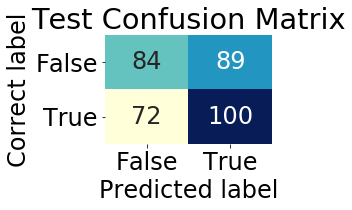

In [17]:
models.test_scores(model_name = "log_reg", 
                   verbose_results = False, 
                   all_metrics = False)

# Logistic Regression is better at detecting truth than detecting deception: 
## deception detection: 49% accuracy -> (correctly predicted deception /  (correctly predicted deception + mispredicted deception))
## truth detection: 58% accuracy

CV ACCURACY SCORE: 0.61
CV PARAMS:  {'alpha': 1}

Accuracy on test data: 0.54

Classification Report on test data:
               precision    recall  f1-score   support

       False       0.56      0.39      0.46       173
        True       0.53      0.69      0.60       172

   micro avg       0.54      0.54      0.54       345
   macro avg       0.55      0.54      0.53       345
weighted avg       0.55      0.54      0.53       345



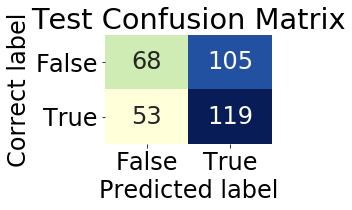

In [18]:
models.test_scores(model_name = "mnb", 
                   verbose_results = False, 
                   all_metrics = False)

# Multinomial Naive Bayes is much better at detecting truth and much worse at detecting deception: 
## deception detection: 39% accuracy -> (correctly predicted deception /  (correctly predicted deception + mispredicted deception))
## truth detection: 69% accuracy

# Full Normalization * Bow Model * 3 Classifiers

In [19]:
models = Binary_Classification(x = df.full_normalization, 
                               y = df[["veracity"]], 
                               scoring = "accuracy", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = CountVectorizer(lowercase = False))
                     
models.compare()

*** log_reg ***
CV ACCURACY SCORE: 0.59
CV PARAMS:  {'C': 0.1}

*** mnb ***
CV ACCURACY SCORE: 0.59
CV PARAMS:  {'alpha': 1}

*** ran_for ***
CV ACCURACY SCORE: 0.57
CV PARAMS:  {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}



CV ACCURACY SCORE: 0.59
CV PARAMS:  {'C': 0.1}

Accuracy on test data: 0.55

Classification Report on test data:
               precision    recall  f1-score   support

       False       0.55      0.57      0.56       173
        True       0.55      0.53      0.54       172

   micro avg       0.55      0.55      0.55       345
   macro avg       0.55      0.55      0.55       345
weighted avg       0.55      0.55      0.55       345



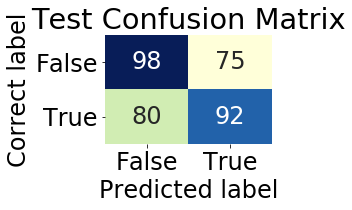

In [20]:
models.test_scores(model_name = "log_reg", 
                   verbose_results = False, 
                   all_metrics = False)

CV ACCURACY SCORE: 0.59
CV PARAMS:  {'alpha': 1}

Accuracy on test data: 0.56

Classification Report on test data:
               precision    recall  f1-score   support

       False       0.57      0.47      0.52       173
        True       0.55      0.65      0.59       172

   micro avg       0.56      0.56      0.56       345
   macro avg       0.56      0.56      0.56       345
weighted avg       0.56      0.56      0.56       345



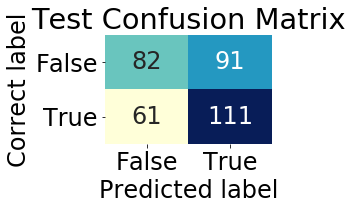

In [21]:
models.test_scores(model_name = "mnb", 
                   verbose_results = False, 
                   all_metrics = False)

# Again, Multinomial Naive Bayes is much better at detecting truth

# BoW Model Summary
## None of the models substantially outperform any other model; While full normalization tends to do worse on predicting the training data, it does marginally better on predicting the test data

### BoW's weakness is that words lose context as they are analyzed independently and w/o order

# n-gram model
### n-gram models attempt to make up for Bow's independent treatment of words by giving them context (i.e., dependence)

an n = 2 model example:

step 1 - original sentence   : NLP is amazing; truly NLP is amazing. 

step 2 - n = 2 n-grammed     : NLP is, is amazing, amazing truly, truly NLP, NLP is (repeated), is amazing (repeated)

step 3 - mapped to frequency : (2, 2, 1, 1)

#### a bag of words model is simply n = 1

in general, n >= 4 is not useful as
n-grams of size 4+ are exceedingly rare

source: https://www.datacamp.com/courses/feature-engineering-for-nlp-in-python

# Light Normalization * N-gram Models (1-2 & 1-3) * 3 Classifiers

In [41]:
models = Binary_Classification(x = df.light_normalization, 
                               y = df[["veracity"]], 
                               scoring = "accuracy", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,2)))
                     
models.compare()

*** log_reg ***
CV ACCURACY SCORE: 0.61
CV PARAMS:  {'C': 1}

*** mnb ***
CV ACCURACY SCORE: 0.61
CV PARAMS:  {'alpha': 1}

*** ran_for ***
CV ACCURACY SCORE: 0.59
CV PARAMS:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 30}



CV ACCURACY SCORE: 0.61
CV PARAMS:  {'C': 1}

Accuracy on test data: 0.58

ROC AUC on test data: 0.58

F1 on test data: 0.58

Classification Report on test data:
               precision    recall  f1-score   support

       False       0.58      0.58      0.58       173
        True       0.58      0.58      0.58       172

   micro avg       0.58      0.58      0.58       345
   macro avg       0.58      0.58      0.58       345
weighted avg       0.58      0.58      0.58       345



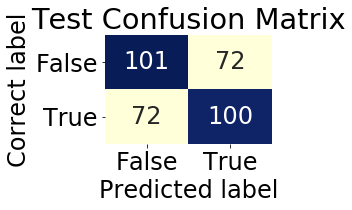

In [42]:
models.test_scores(model_name = "log_reg", 
                   verbose_results = False, 
                   all_metrics = False)

# Logistic Regression seems adept at detecting both deception and truth with equal accuracy

CV ACCURACY SCORE: 0.61
CV PARAMS:  {'alpha': 1}

Accuracy on test data: 0.57

Classification Report on test data:
               precision    recall  f1-score   support

       False       0.60      0.44      0.51       173
        True       0.56      0.70      0.62       172

   micro avg       0.57      0.57      0.57       345
   macro avg       0.58      0.57      0.56       345
weighted avg       0.58      0.57      0.56       345



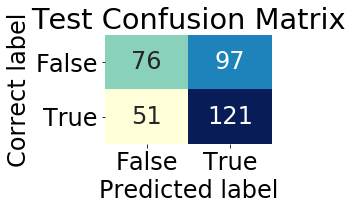

In [24]:
models.test_scores(model_name = "mnb", 
                   verbose_results = False, 
                   all_metrics = False)

# Again, Multinomial Naive Bayes seems a good candidate when detecting innocence is more important

In [47]:
models = Binary_Classification(x = df.light_normalization, 
                               y = df[["veracity"]], 
                               scoring = "accuracy", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,3)))
                     
models.compare()

*** log_reg ***
CV ACCURACY SCORE: 0.6
CV PARAMS:  {'C': 0.1}

*** mnb ***
CV ACCURACY SCORE: 0.62
CV PARAMS:  {'alpha': 1}

*** ran_for ***
CV ACCURACY SCORE: 0.57
CV PARAMS:  {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}



CV ROC_AUC SCORE: 0.66
CV PARAMS:  {'alpha': 5}

ROC AUC on test data: 0.61

Classification Report on test data:
               precision    recall  f1-score   support

       False       0.60      0.32      0.42       173
        True       0.54      0.79      0.64       172

   micro avg       0.55      0.55      0.55       345
   macro avg       0.57      0.55      0.53       345
weighted avg       0.57      0.55      0.53       345



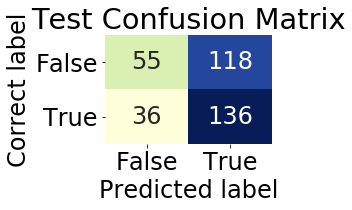

In [46]:
models.test_scores(model_name = "mnb", 
                   verbose_results = False, 
                   all_metrics = False)

# Full Normalization * N-gram Models (1-2 & 1-3) * 3 Classifiers

In [27]:
models = Binary_Classification(x = df.full_normalization, 
                               y = df[["veracity"]], 
                               scoring = "accuracy", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,2)))
                     
models.compare()

*** log_reg ***
CV ACCURACY SCORE: 0.59
CV PARAMS:  {'C': 0.001}

*** mnb ***
CV ACCURACY SCORE: 0.58
CV PARAMS:  {'alpha': 5}

*** ran_for ***
CV ACCURACY SCORE: 0.56
CV PARAMS:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 30}



CV ACCURACY SCORE: 0.59
CV PARAMS:  {'C': 0.001}

Accuracy on test data: 0.54

Classification Report on test data:
               precision    recall  f1-score   support

       False       0.54      0.52      0.53       173
        True       0.54      0.56      0.55       172

   micro avg       0.54      0.54      0.54       345
   macro avg       0.54      0.54      0.54       345
weighted avg       0.54      0.54      0.54       345



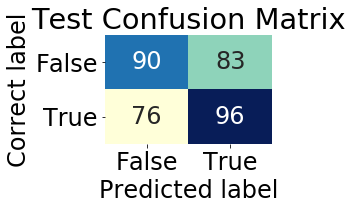

In [28]:
models.test_scores(model_name = "log_reg", 
                   verbose_results = False, 
                   all_metrics = False)

In [29]:
models = Binary_Classification(x = df.full_normalization, 
                               y = df[["veracity"]], 
                               scoring = "accuracy", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,3)))
                     
models.compare()

*** log_reg ***
CV ACCURACY SCORE: 0.59
CV PARAMS:  {'C': 1}

*** mnb ***
CV ACCURACY SCORE: 0.59
CV PARAMS:  {'alpha': 10}

*** ran_for ***
CV ACCURACY SCORE: 0.56
CV PARAMS:  {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}



CV ACCURACY SCORE: 0.59
CV PARAMS:  {'C': 1}

Accuracy on test data: 0.56

Classification Report on test data:
               precision    recall  f1-score   support

       False       0.56      0.55      0.56       173
        True       0.56      0.57      0.56       172

   micro avg       0.56      0.56      0.56       345
   macro avg       0.56      0.56      0.56       345
weighted avg       0.56      0.56      0.56       345



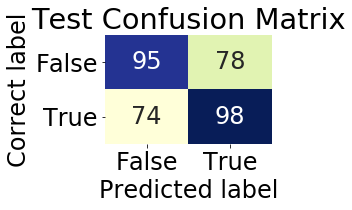

In [30]:
models.test_scores(model_name = "log_reg", 
                   verbose_results = False, 
                   all_metrics = False)

CV ACCURACY SCORE: 0.59
CV PARAMS:  {'alpha': 10}

Accuracy on test data: 0.55

Classification Report on test data:
               precision    recall  f1-score   support

       False       0.58      0.41      0.48       173
        True       0.54      0.70      0.61       172

   micro avg       0.55      0.55      0.55       345
   macro avg       0.56      0.55      0.54       345
weighted avg       0.56      0.55      0.54       345



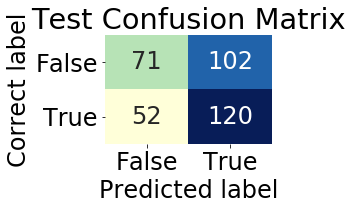

In [31]:
models.test_scores(model_name = "mnb", 
                   verbose_results = False, 
                   all_metrics = False)

# n-gram Model Summary
### again no model greatly outperformed any other; full normalization performs worse on training and test prediction for n-gram sizes 1-2 and 1-3

# Term Frequency-Inverse Document Frequency (tf-idf) model

Terms given score based on: 

(1) frequency in single text and 

(2) frequency in all texts

In [32]:
models = Binary_Classification(x = df.light_normalization, 
                               y = df[["veracity"]], 
                               scoring = "accuracy", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = TfidfVectorizer(lowercase = False, ngram_range = (1,2)))
                     
models.compare()

*** log_reg ***
CV ACCURACY SCORE: 0.63
CV PARAMS:  {'C': 1}

*** mnb ***
CV ACCURACY SCORE: 0.62
CV PARAMS:  {'alpha': 1}

*** ran_for ***
CV ACCURACY SCORE: 0.59
CV PARAMS:  {'criterion': 'gini', 'max_depth': 12, 'max_features': 'log2', 'n_estimators': 30}



CV ACCURACY SCORE: 0.63
CV PARAMS:  {'C': 1}

Accuracy on test data: 0.57

Classification Report on test data:
               precision    recall  f1-score   support

       False       0.59      0.50      0.54       173
        True       0.56      0.65      0.60       172

   micro avg       0.57      0.57      0.57       345
   macro avg       0.58      0.57      0.57       345
weighted avg       0.58      0.57      0.57       345



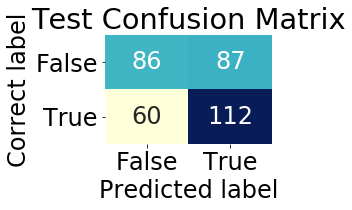

In [33]:
models.test_scores(model_name = "log_reg", 
                   verbose_results = False, 
                   all_metrics = False)

# doesn't perform better than a simple n-gram model

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.

        ex) features = "Trump", "people", "the"
* use the trained classifier to make predictions on this matrix

        ex) clf.pred(features)
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

        ex) Trump & 89%, people & 10%, the & 1%

In [34]:
_ , itest = train_test_split(range(df.shape[0]), test_size=0.3, random_state = 0)
mask = np.zeros(df.shape[0], dtype=np.bool)
mask[itest] = True

In [35]:
def make_xy(df, features, target, vectorizer = None):
    X = vectorizer.fit_transform(df[features]) 
    y = (df[target] == True)
    return X, y

vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,3))

X, y = make_xy(df, "light_normalization", "veracity", vectorizer)

xtrain = X[mask]
ytrain = y[mask]
xtest = X[~mask]
ytest = y[~mask]

model = MultinomialNB(1).fit(xtrain, ytrain)

training_accuracy = model.score(xtrain, ytrain)
test_accuracy = model.score(xtest, ytest)

print("Accuracy on training data: ", "{:.2f}".format(training_accuracy))
print("Accuracy on test data:     ", "{:.2f}".format(test_accuracy))

Accuracy on training data:  1.00
Accuracy on test data:      0.53


In [36]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = model.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

truth_words = words[ind[:10]]
falsehood_words = words[ind[-10:]]

truth_prob = probs[ind[:10]]
falsehood_prob = probs[ind[-10:]]

print("Truth words       P(true | word)")
for w, p in zip(truth_words, truth_prob):
    print("{:>25}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print()

print("Falsehood words   P(true | word)")
for w, p in zip(falsehood_words, falsehood_prob):
    print("{:>25}".format(w), "{:.2f}".format(1 - np.exp(p)))

Truth words       P(true | word)
                   nation 0.87
                      die 0.86
                     york 0.86
               in america 0.86
                      law 0.86
               the nation 0.86
                     born 0.86
                   deaths 0.86
                 new york 0.86
                   we are 0.83

Falsehood words   P(true | word)
                    voted 0.16
                   really 0.16
                democrats 0.16
                     side 0.16
               first time 0.16
                    would 0.16
           the first time 0.16
                  support 0.14
           administration 0.14
                    scott 0.14
